Effect of Noise on VQE
==================

The Variation Quantum Eigensolver (VQE) algorithm has multiple steps. The effect of noise at each individual step on the end result differs, with important consequences for the surface that the classical optimizer sees. On the face of it, noise reduction is always a good thing. However, VQE is also an iterative algorithm, which means that it has intermediate results that will be discarded after use; and has a classical sum, which means that some terms contribute more than others to the final result. Thus, not all noise is equally bad, and understanding the disparate impact allows setting up a workflow that best utilizes the available tools and resources (both quantum and classical).

<img src='./figs/vqe_structure.png'>

It is useful to recognize three main error categories:

* initialization error
* preparation error
* measurement error

**Initialization errors**, caused by gate errors in, or decay during, the creation of the initial state from the computational null state, effectively set up an incorrect configuration (e.g. more or fewer particles than intended, or of a different type). The effects may be large enough to flag shots with such errors in post-selection. Otherwise, the result is a, possibly biased, smearing of the final output distribution.

**Preparation errors**, caused by gate errors in, or decay during, the Ansatz portion of the algorithm, result in a different trial state to be prepared than the optimizer intended. If the Ansatz is configuration preserving (this is typical), but the configuration of the trial state is now off due to the errors, then just like initialization errors, this may be detectable. More likely, the trial state is still close to, but not at, the intended state. Since all states with the correct configuration that are not the ground state result in an estimated energy higher than the minimum, the net effect is a "lifting" of the optimization surface.

**Measurement errors**, which for this discussion includes errors in the base rotations gates, misclassification, and sampling errors, mean that effectively different components are measured than the ones that make up the chosen Hamiltonian (e.g. measuring 'IXYI' where 'XXYI' was intended because of a bit flip on qubit 0). If the components are different, the calculated Hamiltonian is different. Since the components are measured through independent experiments, the result will be an approximately Gaussian distribution in the limit (i.e. with many components in the Hamiltonian), because of the central limit theorem. Whether the result will be biased depends on the Hamiltonian, the prepared state, and the noise profile of the hardware.

In [1]:
import hubbard as hb
import noise_model as noise
import multiprocessing as mp
import numpy as np
import os

from matplotlib import pyplot as plt

In [2]:
import logging

logging.getLogger('hubbard').setLevel(logging.INFO)

<div class="alert alert-block alert-info">
<b>Tip:</b> Running the full simulation may be too slow on a laptop in a (time-constrained) tutorial setting. It is recommended in that case to only run a few shots and simply use larger error settings to see the basic effects. The settings below reflect this recommendation.
</div>

In [3]:
# Select the number of processes to use in parallel
n_processes = os.cpu_count() // 2

# Number of evaluations per graph
n_evals = max(8, n_processes)
print("number of evaluations:", n_evals)

number of evaluations: 8


Model Setup
---------------

In the examples below, we will use the same Hubbard Model setup as before. For proper comparison, consider the noise-free calculation of the ground energy on the Ansatz as this depends on the number of Trotter steps chosen, rather than the exact solution.

In [4]:
# Select a model appropriate for the machine used:
#    laptop -> use small model
#    server -> use medium model

MODEL = hb.small_model
#MODEL = hb.medium_model

# Hubbard model for fermions (Fermi-Hubbard) required parameters
xdim, ydim, t, U, chem, magf, periodic, spinless = MODEL()

# Number of electrons to add to the system
n_electrons_up   = 1
n_electrons_down = 1
n_electrons = n_electrons_up + n_electrons_down

# Total number of "sites", with each qubit representing occupied or not
spinfactor = spinless and 1 or 2
n_qubits = n_sites = xdim * ydim * spinfactor

# Create the Hubbard Model for use with Qiskit
hubbard_op = hb.hamiltonian_qiskit(
    x_dimension        = xdim,
    y_dimension        = ydim,
    tunneling          = t,
    coulomb            = U,
    chemical_potential = chem,
    magnetic_field     = magf,
    periodic           = periodic,
    spinless           = spinless)

# Retrieve the pre-calculated optimal parameters
par_at_opt = MODEL.optimal(n_electrons_up, n_electrons_down)

# Note that the estimate energy will be somewhat off, due to the
# limited number of trotter steps (here: 2)
print("expected: %.5f" % hb.EnergyObjective(hubbard_op, n_electrons_up, n_electrons_down)(par_at_opt))
print("exact:    %.5f" % hb.exact(hubbard_op, n_electrons_up, n_electrons_down))

hubbard                |     INFO - objective: -1.16570 @ [ 2.20376576 -0.46984311]
expected: -1.16570
exact:    -1.23607


Effect of Preparation Errors
--------------------------------

First, we will consider the effect of state preparation errors on the calculated energy at the optimal parameters by step-wise increasing the chances of polarization errors in single and 2-qubit gates.

In [5]:
# Noise step size and scale to use
noise_scale = 10.
noise_step_1q = 1.E-5 * (noise_scale/n_evals)
noise_step_2q = 1.E-4 * (noise_scale/n_evals)

# For controlling exercise below
trotter_steps = 2

In [6]:
def plot_graph(x, Y):
    """\
    Helper to plot results from the noise studies.
    
    Args:
       x (tuple of (np.array, label)): x coordinates and label
       Y (tuple of (np.array, label)) pairs: y coordinates and their label
    """

    plt.figure()
    for y, ylabel in Y:
        plt.plot(x[0], y, label=ylabel)
    plt.legend(loc='upper left')
    plt.xlabel(x[1])
    plt.ylabel('expectation at optimum')
    plt.show()

In [7]:
# save the first run with default settings for later use
saved_result = None

In [8]:
# The following uses Python's multiprocessing. If this fails for you,
# change it to a simple loop and run sequentially.
def scan_noise():
    global noise_scale, noise_step_1q, noise_step_2q, trotter_steps

    with mp.Pool(n_processes) as p:
        futs = []
        for i in range(n_evals):
            objective = hb.EnergyObjective(hubbard_op, n_electrons_up, n_electrons_down,
                noise_model=noise.create(p_gate_1q=noise_step_1q*i, p_gate_2q=noise_step_2q*i),
                trotter_steps=trotter_steps)
            futs.append(p.apply_async(objective, (par_at_opt,)))

        result = [f.get() for f in futs]
    
    return result

result = scan_noise()

# save the first run with default settings for later use
if saved_result is None:
    saved_result = result[:]

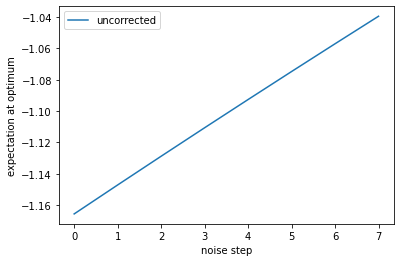

In [9]:
plot_graph((range(n_evals), 'noise step'), [(result, 'uncorrected')])

Note that at low noise level, the effect of incremental noise is roughly linear, something that can be exploited in post-processing using the zero-noise extrapolation (ZNE) technique.$^{1,2}$

**Exercise:** Change the number of Trotter steps, plot against the original results and explain the relative differences. What is better, more or fewer Trotter steps?

**Exercise:** Increase the scale to some huge number (e.g. 1000); explain the asymptotic behavior.

**Optional Exercise:** simulate single and 2-qubit gate noise independently and compare and explain the results. E.g., why do the results reach an asymptotic value at high noise?

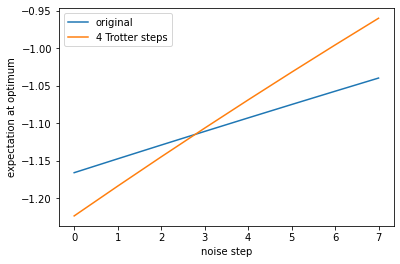

In [10]:
# with 4 Trotter steps
noise_scale = 10.
noise_step_1q = 1.E-5 * (noise_scale/n_evals)
noise_step_2q = 1.E-4 * (noise_scale/n_evals)
trotter_steps = 4

result = scan_noise()
plot_graph((range(n_evals), 'noise step'), [(saved_result, 'original'), (result, '4 Trotter steps')])

As can be seen from the figure, there is a clear trade-off: at low noise level, the better approximation afforded with more Trotter steps improves the result. However, at high noise, the increase in depth because of the additional Trotter steps worsens the final outcome.

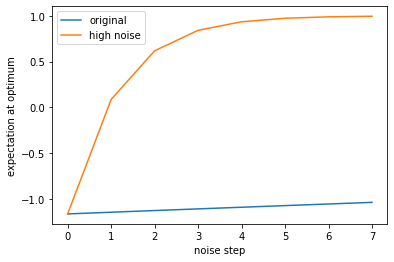

In [11]:
# with noise scale of 1000.
noise_scale = 1000.
noise_step_1q = 1.E-5 * (noise_scale/n_evals)
noise_step_2q = 1.E-4 * (noise_scale/n_evals)
trotter_steps = 2

result = scan_noise()
plot_graph((range(n_evals), 'noise step'), [(saved_result, 'original'), (result, 'high noise')])

At high noise, there is no information in a measurement: all will simply yield $0.5$. This is multiplied with the components' coefficients and summed (classical steps, so not affected by quantum noise), reaching the asymptotic value observed.

### Effect of BQSKit optimization

Next, we'll add the BQSKit optimization step to see the improvement as a function of noise level of having fewer gates (in particular CNOTs) in the circuit. Note that the noise model chosen only considers depolarization errors and the overall improvement will be better than simulated here.

<div class="alert alert-block alert-info">
<b>Tip:</b> BQSKit has randomized algorithms, so the result you get may be "unlucky" and that streak will be baked in, because the result will be used across all noise levels. Thus, if there are more than, say, 45 CNOTs left, consider rerunning the cell.</div>

In [12]:
# Noise step size and scale to use
noise_scale = 10.
noise_step_1q = 1.E-5 * (noise_scale/n_evals)
noise_step_2q = 1.E-4 * (noise_scale/n_evals)

In [13]:
# To save time, cache the BQSKit optimized circuit, then run through the
# range of noise levels re-using this cached circuit

result_bqskit = []

# first run, with BQSKit optimization for the base case w/o noise (note:
# if this is too slow, set 'run_bqskit=True' instead, which will run only
# a single optimization round, rather than until full convergence)
objective = hb.EnergyObjective(hubbard_op, n_electrons_up, n_electrons_down,
    noise_model=None, trotter_steps=2, run_bqskit='full')
result_bqskit.append(objective(par_at_opt, use_cached_circuit=True))

# run over the remaining noise-levels, using the cached circuit
with mp.Pool(n_processes) as p:
    futs = []
    for i in range(1, n_evals):
        objective = hb.EnergyObjective(hubbard_op, n_electrons_up, n_electrons_down,
            noise_model=noise.create(p_gate_1q=noise_step_1q*i, p_gate_2q=noise_step_2q*i),
            trotter_steps=2, run_bqskit=True)
        futs.append(p.apply_async(objective, (par_at_opt, hb.get_cached_circuit())))

    result = [f.get() for f in futs]

result_bqskit += result
hb.clear_circuit_cache()

BQSKit step, current CNOT count: 92
BQSKit step, current CNOT count: 58
BQSKit step, current CNOT count: 54
BQSKit step, current CNOT count: 49
BQSKit step, current CNOT count: 46
BQSKit step, current CNOT count: 42
BQSKit step, current CNOT count: 40
BQSKit step, current CNOT count: 40
BQSKit completed in 42.32s
hubbard                |     INFO - objective: -1.16570 @ [ 2.20376576 -0.46984311]


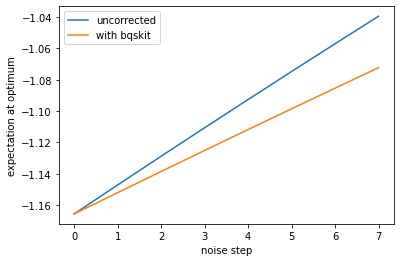

In [14]:
plot_graph((range(n_evals), 'noise step'), [(saved_result, 'uncorrected'), (result_bqskit, 'with bqskit')])

<table style="padding: 0px"><tr></tr><tr>
<td style="width: 50%; padding: 0px">
<div align="left" style="text-align: left; font-size: 120%">
As can be seen, the reduction in CNOT by BQSKit does not lead to a proportional reduction in the noise impact on the final result (as opposed to the impact of overall noise, which is seen to be roughly linear). This can be understood from the figure on the right: noise causes a deviation from the intended trial state, but the further away, the less of an impact the next random steps have, because the total volume to randomly step into has increased (from starting at zero, at the intended state).

<br>This is similar to what happens in a (Gaussian) random walk distribution of fixed steps, where the distance from the starting point increases with $\sqrt N$, with similar subdued impact from each additional step at large $N$.
</div></td>
    <td>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;</td>
<td style="width: 50%">
    <img src='./figs/stochastic_noise.png'>
</td>
</tr></table>

Effect of Measurement Errors
-----------------------------------

Classification errors are function of the readout quality, which is (assuming correct calibration) mostly a given for a specific hardware setup. Sampling error, however, can be reduced by increasing the number of shots. Increased sampling may or may not reduce the impact of misclassification, as those errors are possibly biased.

In [15]:
# Probability of misclassification
p_meas = 0.02

# Number of evaluation points (Note: do not make this number too large,
# see the exponentation in the inner loop below)
n_meas_evals = n_evals * 2

In [16]:
# The following uses Python's multiprocessing. If this fails for you,
# change it to a simple loop and run sequentially.
with mp.Pool(n_processes) as p:
    futs = []
    for i in range(n_meas_evals):
        objective = hb.EnergyObjective(hubbard_op, n_electrons_up, n_electrons_down,
            noise_model=noise.create(p_meas=p_meas), shots=2**(8+i/2),
            trotter_steps=2)
        futs.append(p.apply_async(objective, (par_at_opt,)))

    result = [f.get() for f in futs]

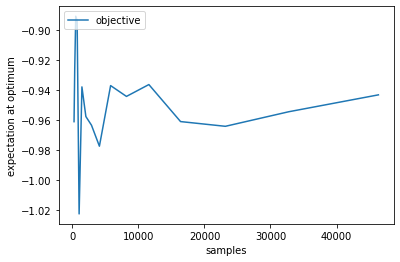

In [17]:
plot_graph(([2**(8+i/2) for i in range(n_meas_evals)], 'samples'), [(result, 'objective')])

### Optional Exercises

Consider the following possible studies (time consuming):

* Simulate classification and sampling errors independently and compare
* For a given classification error, find the point where further sampling does not improve the result
* Plot full distributions of single-shot evaluations as a function of error level

References
-------------

[1] https://arxiv.org/abs/1612.02058, K. Temme, S. Bravyi, J.M. Gambetta, "Error Mitigation for Short-Depth Quantum Circuits", Phys. Rev. Lett. 119(18), Dec. 2016
<br>[2] https://arxiv.org/abs/1611.09301 Y. Li, S.C. Benjamin, "Efficient Variational Quantum Simulator Incorporating Active Error Minimization", Phys. Rev. X 7, 021050 (2017)